In [4]:
from fastai.vision.all import *
import fastai
import timm
import torch

In [5]:
torch.cuda.set_device(2)

In [6]:
df = pd.read_csv('../trainValid.csv')

In [7]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [8]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 384

In [9]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='swin_base_patch4_window7_224',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [10]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [11]:
dls = db.dataloaders(df.values,bs=16,num_workers=0)

In [12]:
learn = Learner(dls,timm.create_model('swin_base_patch4_window7_224',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

SuggestedLRs(valley=6.918309736647643e-06)

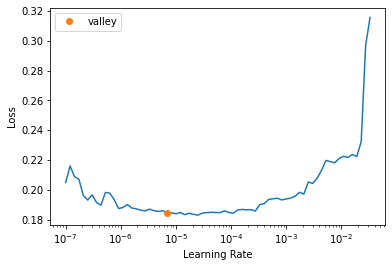

In [13]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.181905,0.209177,0.505128,0.502632,0.979487,0.664348,0.502646,02:25


Better model found at epoch 0 with f1_score value: 0.6643478260869565.


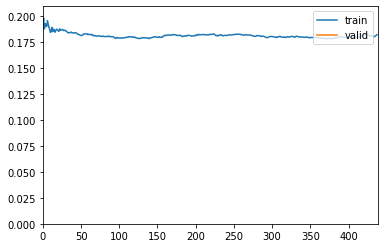

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.175382,0.191900,0.510256,0.505650,0.917949,0.652095,0.506397,02:30
1,0.176066,0.191669,0.510256,0.505571,0.930769,0.655235,0.515546,02:31
2,0.175141,0.190398,0.516667,0.509091,0.933333,0.658824,0.518379,02:29
3,0.176298,0.192021,0.506410,0.503365,0.958974,0.660194,0.525805,02:33
4,0.174650,0.186195,0.515385,0.508523,0.917949,0.654479,0.531036,02:32
5,0.174244,0.182393,0.511538,0.506829,0.856410,0.636797,0.534668,02:28
6,0.175311,0.189030,0.510256,0.505362,0.966667,0.663732,0.546788,02:26
7,0.175437,0.179268,0.528205,0.516369,0.889744,0.653484,0.563508,02:26
8,0.175590,0.182608,0.521795,0.511757,0.948718,0.664870,0.568139,02:25
9,0.175475,0.184798,0.515385,0.508065,0.969231,0.666667,0.571920,02:25


Better model found at epoch 0 with f1_score value: 0.6520947176684881.


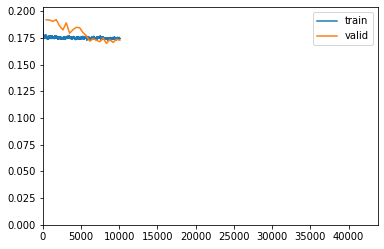

Better model found at epoch 1 with f1_score value: 0.6552346570397112.
Better model found at epoch 2 with f1_score value: 0.6588235294117647.
Better model found at epoch 3 with f1_score value: 0.6601941747572816.
Better model found at epoch 6 with f1_score value: 0.6637323943661971.
Better model found at epoch 8 with f1_score value: 0.664869721473495.
Better model found at epoch 9 with f1_score value: 0.6666666666666667.
Better model found at epoch 10 with f1_score value: 0.6672550750220653.
Better model found at epoch 17 with f1_score value: 0.6690454950936664.
Better model found at epoch 21 with f1_score value: 0.6697332106715731.
Better model found at epoch 22 with f1_score value: 0.6770642201834862.
No improvement since epoch 18: early stopping


In [14]:
learn.fine_tune(100,base_lr=3e-5)

In [15]:
dfTest = pd.read_csv('../testSample.csv')

In [16]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [17]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [18]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [19]:
learn.dls = dlsTest

In [20]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.5842161735700196.


(#6) [0.17372460663318634,0.5297436118125916,0.5166284403669725,0.9241025641025641,0.6627436557557925,0.5842161735700196]